- In this notebook, I show the performance of ONet  
- As I mentioned in the first notebook (step 1), I will not show the repetitive parts. 

## The ONet Box
- Given the image, and the bounding boxes generated from the **rnet box**, it generates the image boxes with the size of 48

- Then, it puts these image boxes into RNet to get prediction boxes, converts the boxes into squares and calibrates them according to the offset values.

- After that, it chooses the boxes that might have face (larger than **MIN_FACE_SIZE**) based on the **THRESHOLDS** and deletes the repetitive boxes based on the **NMS_THRESHOLDS**  
- Finally, it returns the bounding box information to show the images.

In [22]:
def onet_boxes(img, onet, bounding_boxes, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS):
    onet.eval()
    img_boxes = get_image_boxes(bounding_boxes, img, size=48)
    img_boxes = torch.FloatTensor(img_boxes)
    img_boxes = img_boxes.cuda()
    if img_boxes.size(0)==0:
        return []
    output = onet(img_boxes)
    probs = output[0].data.cpu().numpy()
    offsets = output[1].data.cpu().numpy()
    ldmk=output[2].data.cpu().numpy()

    keep = np.where(probs[:, 0] > thresholds[2])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 0].reshape((-1,))
    offsets = offsets[keep]
    ldmk = ldmk[keep]
    
    width = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
    height = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
    xmin, ymin = bounding_boxes[:, 0], bounding_boxes[:, 1]
    ldmk[:, 0:10:2] = np.expand_dims(xmin, 1) + np.expand_dims(width, 1)*ldmk[:,  0:10:2]
    ldmk[:, 1:10:2] = np.expand_dims(ymin, 1) + np.expand_dims(height, 1)*ldmk[:, 1:10:2]

    keep = nms(bounding_boxes, nms_thresholds[2])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
    ldmk=ldmk[keep]
    return bounding_boxes,ldmk

## Show the Boxes and Facial Landmark

(Not The Final Result)

#### Set the parameters and Load Models

In [11]:
landmark_data_dir = '../input/facial-point-detection/Facial_Point_Detection'
landmark_train_txt_path = '../input/facial-point-detection/Facial_Point_Detection/trainImageList.txt'
landmark_eval_txt_path = '../input/facial-point-detection/Facial_Point_Detection/testImageList.txt'
pnet_weight_path='../input/landmark/ldmk-pnet_10000_30 best.pkl'
rnet_weight_path='../input/landmark/ldmk-rnet_9996_60.pkl'
onet_weight_path='../input/landmark/onet_1.pkl'
train_num=None
eval_num=None
class_data_augment = 3 
pnet=P_Net().cuda()
pnet.load_state_dict(torch.load(pnet_weight_path))
pnet.eval()
rnet=R_Net().cuda()
rnet.load_state_dict(torch.load(rnet_weight_path))
rnet.eval()
onet=O_Net().cuda()
onet.load_state_dict(torch.load(onet_weight_path))
onet.eval()

O_Net(
  (pre_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): PReLU(num_parameters=1)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (10): PReLU(num_parameters=1)
  )
  (conv5): Linear(in_features=512, out_features=256, bias=True)
  (prelu5): PReLU(num_parameters=1)
  (conv6_1): Linear(in_features=256, out_features=1, bias=True)
  (conv6_2): Linear(in_features=256, out_features=4, bias=True)
  (conv6_3): Linear(in_features=256, out_features=10, bias=True)
)

#### Show sample images from the training set

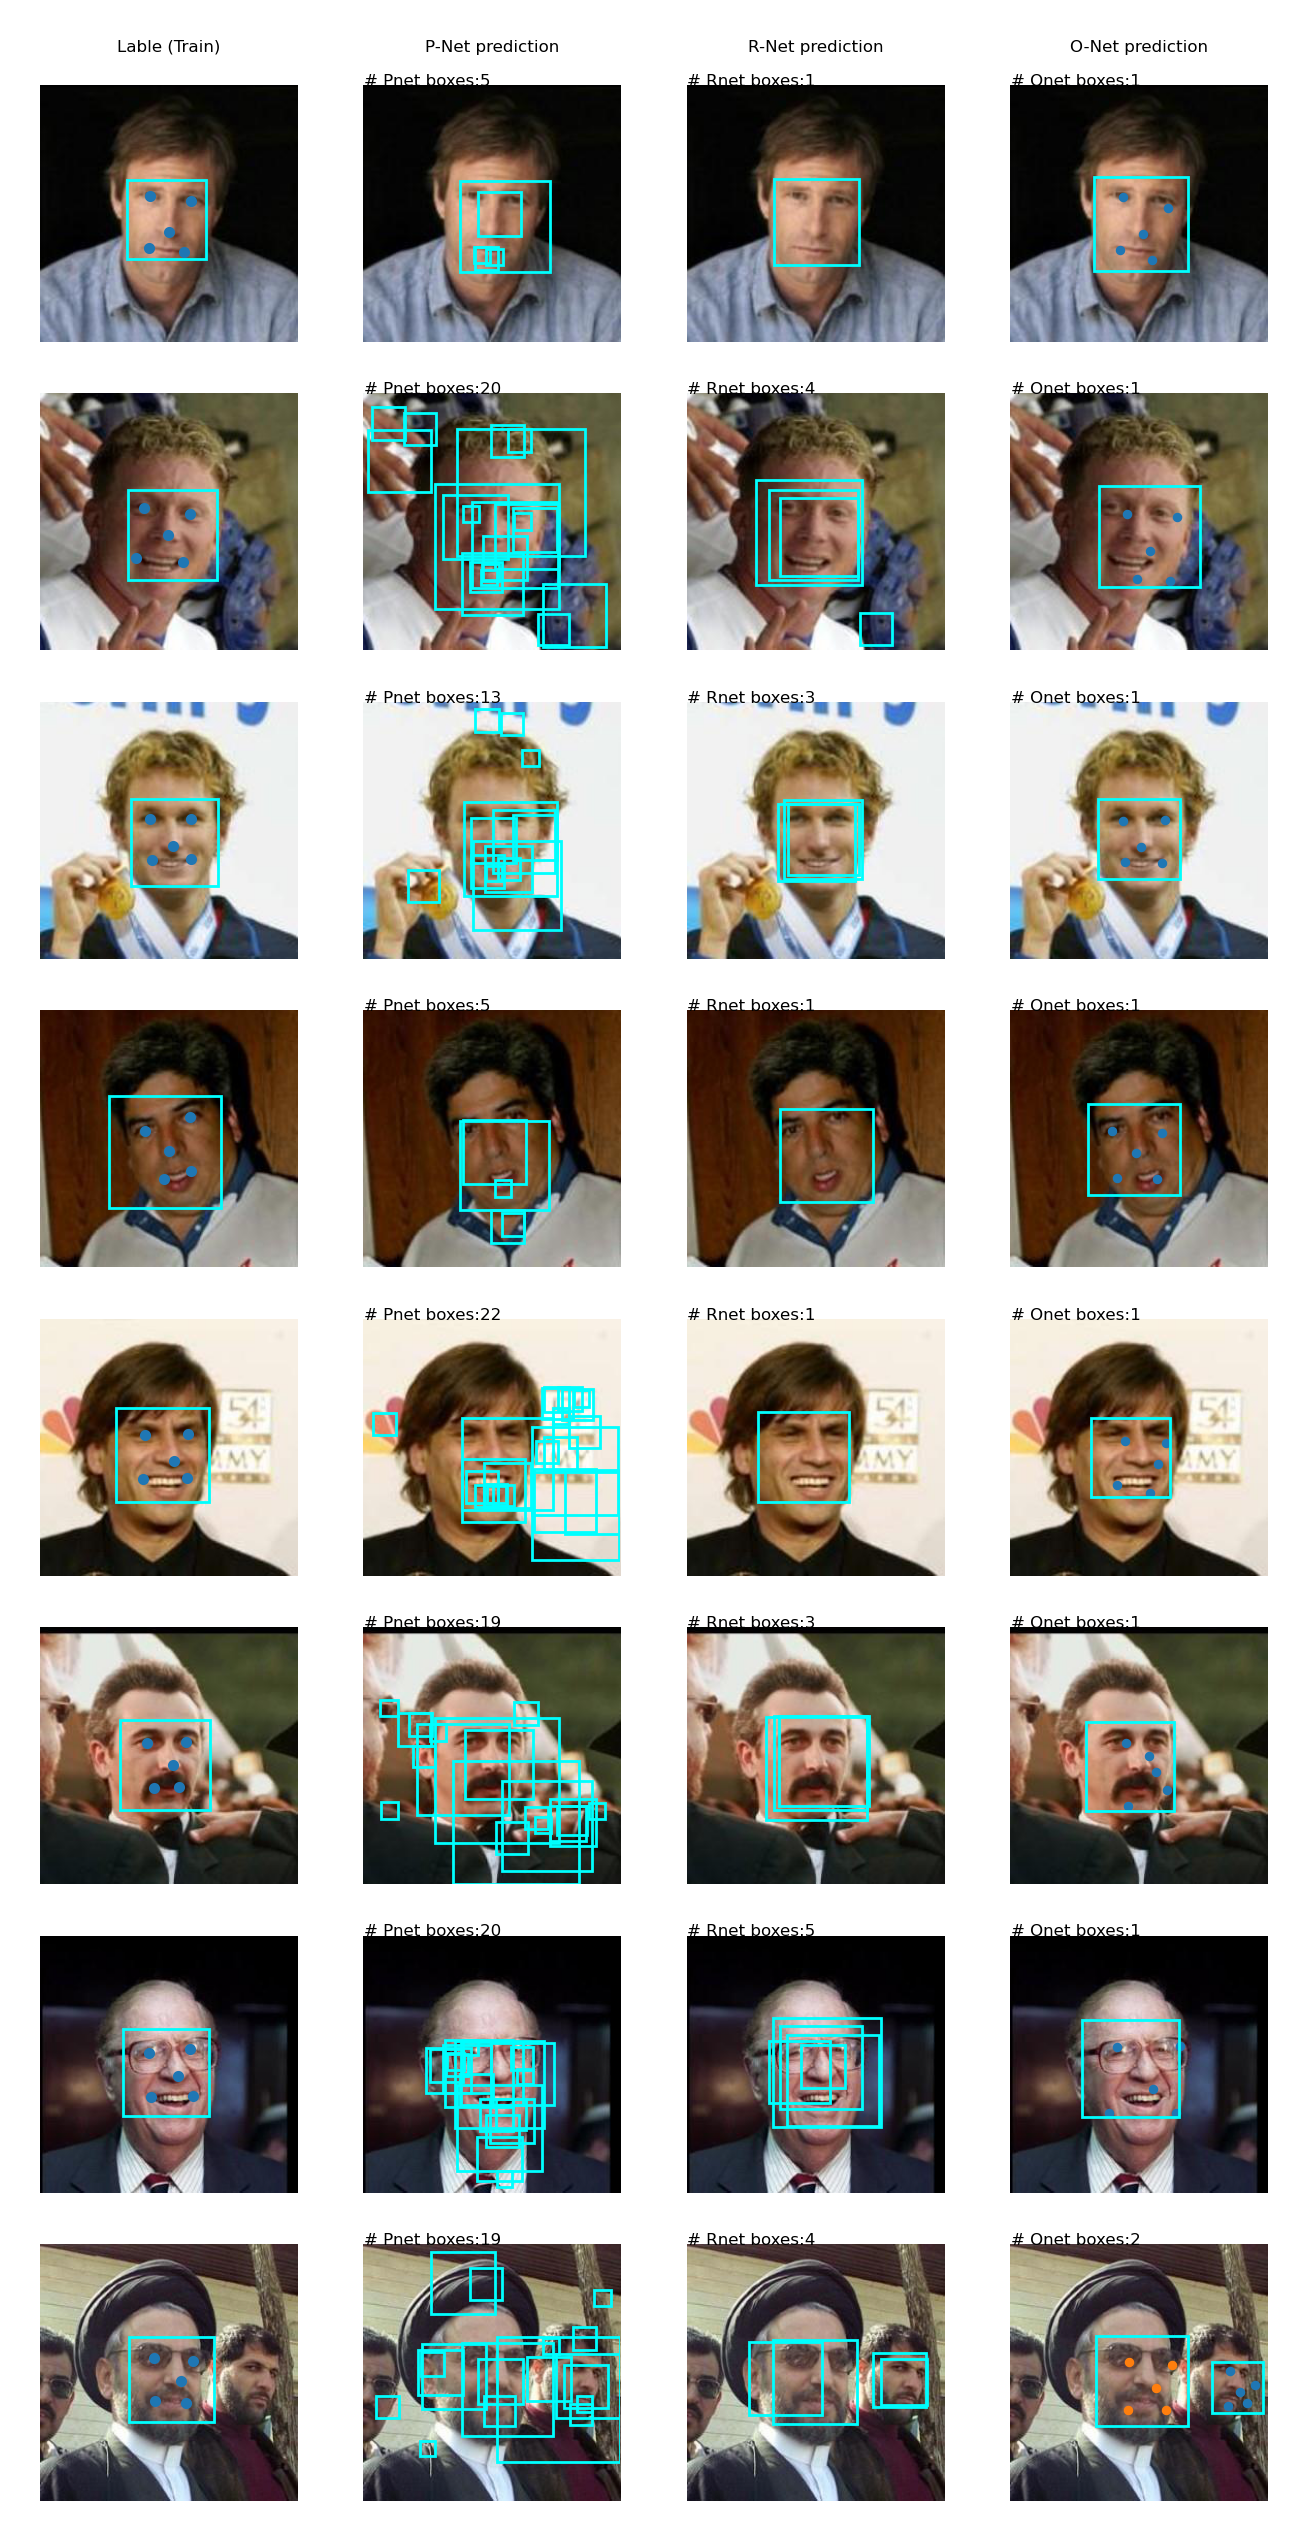

In [23]:
# get 8 fixed images
data_for_demo = landmark_dataset_txt_parser(landmark_train_txt_path, landmark_data_dir,num_data=8)


# demo and plot
fig, ax = plt.subplots(8,4,dpi = 400, figsize=(4,8))

for i in range(len(data_for_demo)):
    img_pth, gts,p = data_for_demo[i]
    gts=np.array(gts)
    if gts.ndim is 1:
        gts = np.expand_dims(gts, 0)
        gts[:, :] = gts[:, (0, 2, 1, 3)]
    img = Image.open(img_pth)
    p_bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    r_bounding_boxes=rnet_boxes(img, rnet, p_bounding_boxes, show_boxes=False)
    try:
        o_bounding_boxes,ldmk=onet_boxes(img, onet, r_bounding_boxes)
    except:
        o_bounding_boxes,ldmk=[],[]
    
    ax[i,0].imshow(img)
    ax[i,0].scatter([p[j*2] for j in range(5)],[p[j*2+1] for j in range(5)],s=1)
    for b in gts:
        ax[i,0].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5));
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# Pnet boxes:'+str(len(p_bounding_boxes)),fontsize=3)
    for b in p_bounding_boxes[:100]:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
    
    ax[i,2].imshow(img)
    ax[i,2].text(0, 0, '# Rnet boxes:'+str(len(r_bounding_boxes)),fontsize=3)
    for b in r_bounding_boxes:
        ax[i,2].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
        
    ax[i,3].imshow(img)
    ax[i,3].text(0, 0, '# Onet boxes:'+str(len(o_bounding_boxes)),fontsize=3)
    for b in o_bounding_boxes:
        ax[i,3].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))  
    for l in ldmk:    
        ax[i,3].scatter([l[j*2] for j in range(5)],[l[j*2+1] for j in range(5)],s=0.5)

for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Lable (Train)",fontsize=3)
ax[0][1].set_title("P-Net prediction",fontsize=3)
ax[0][2].set_title("R-Net prediction",fontsize=3)
ax[0][3].set_title("O-Net prediction",fontsize=3)
fig.show()
fig.savefig('demo_train.png')

#### Show sample images from the eval set

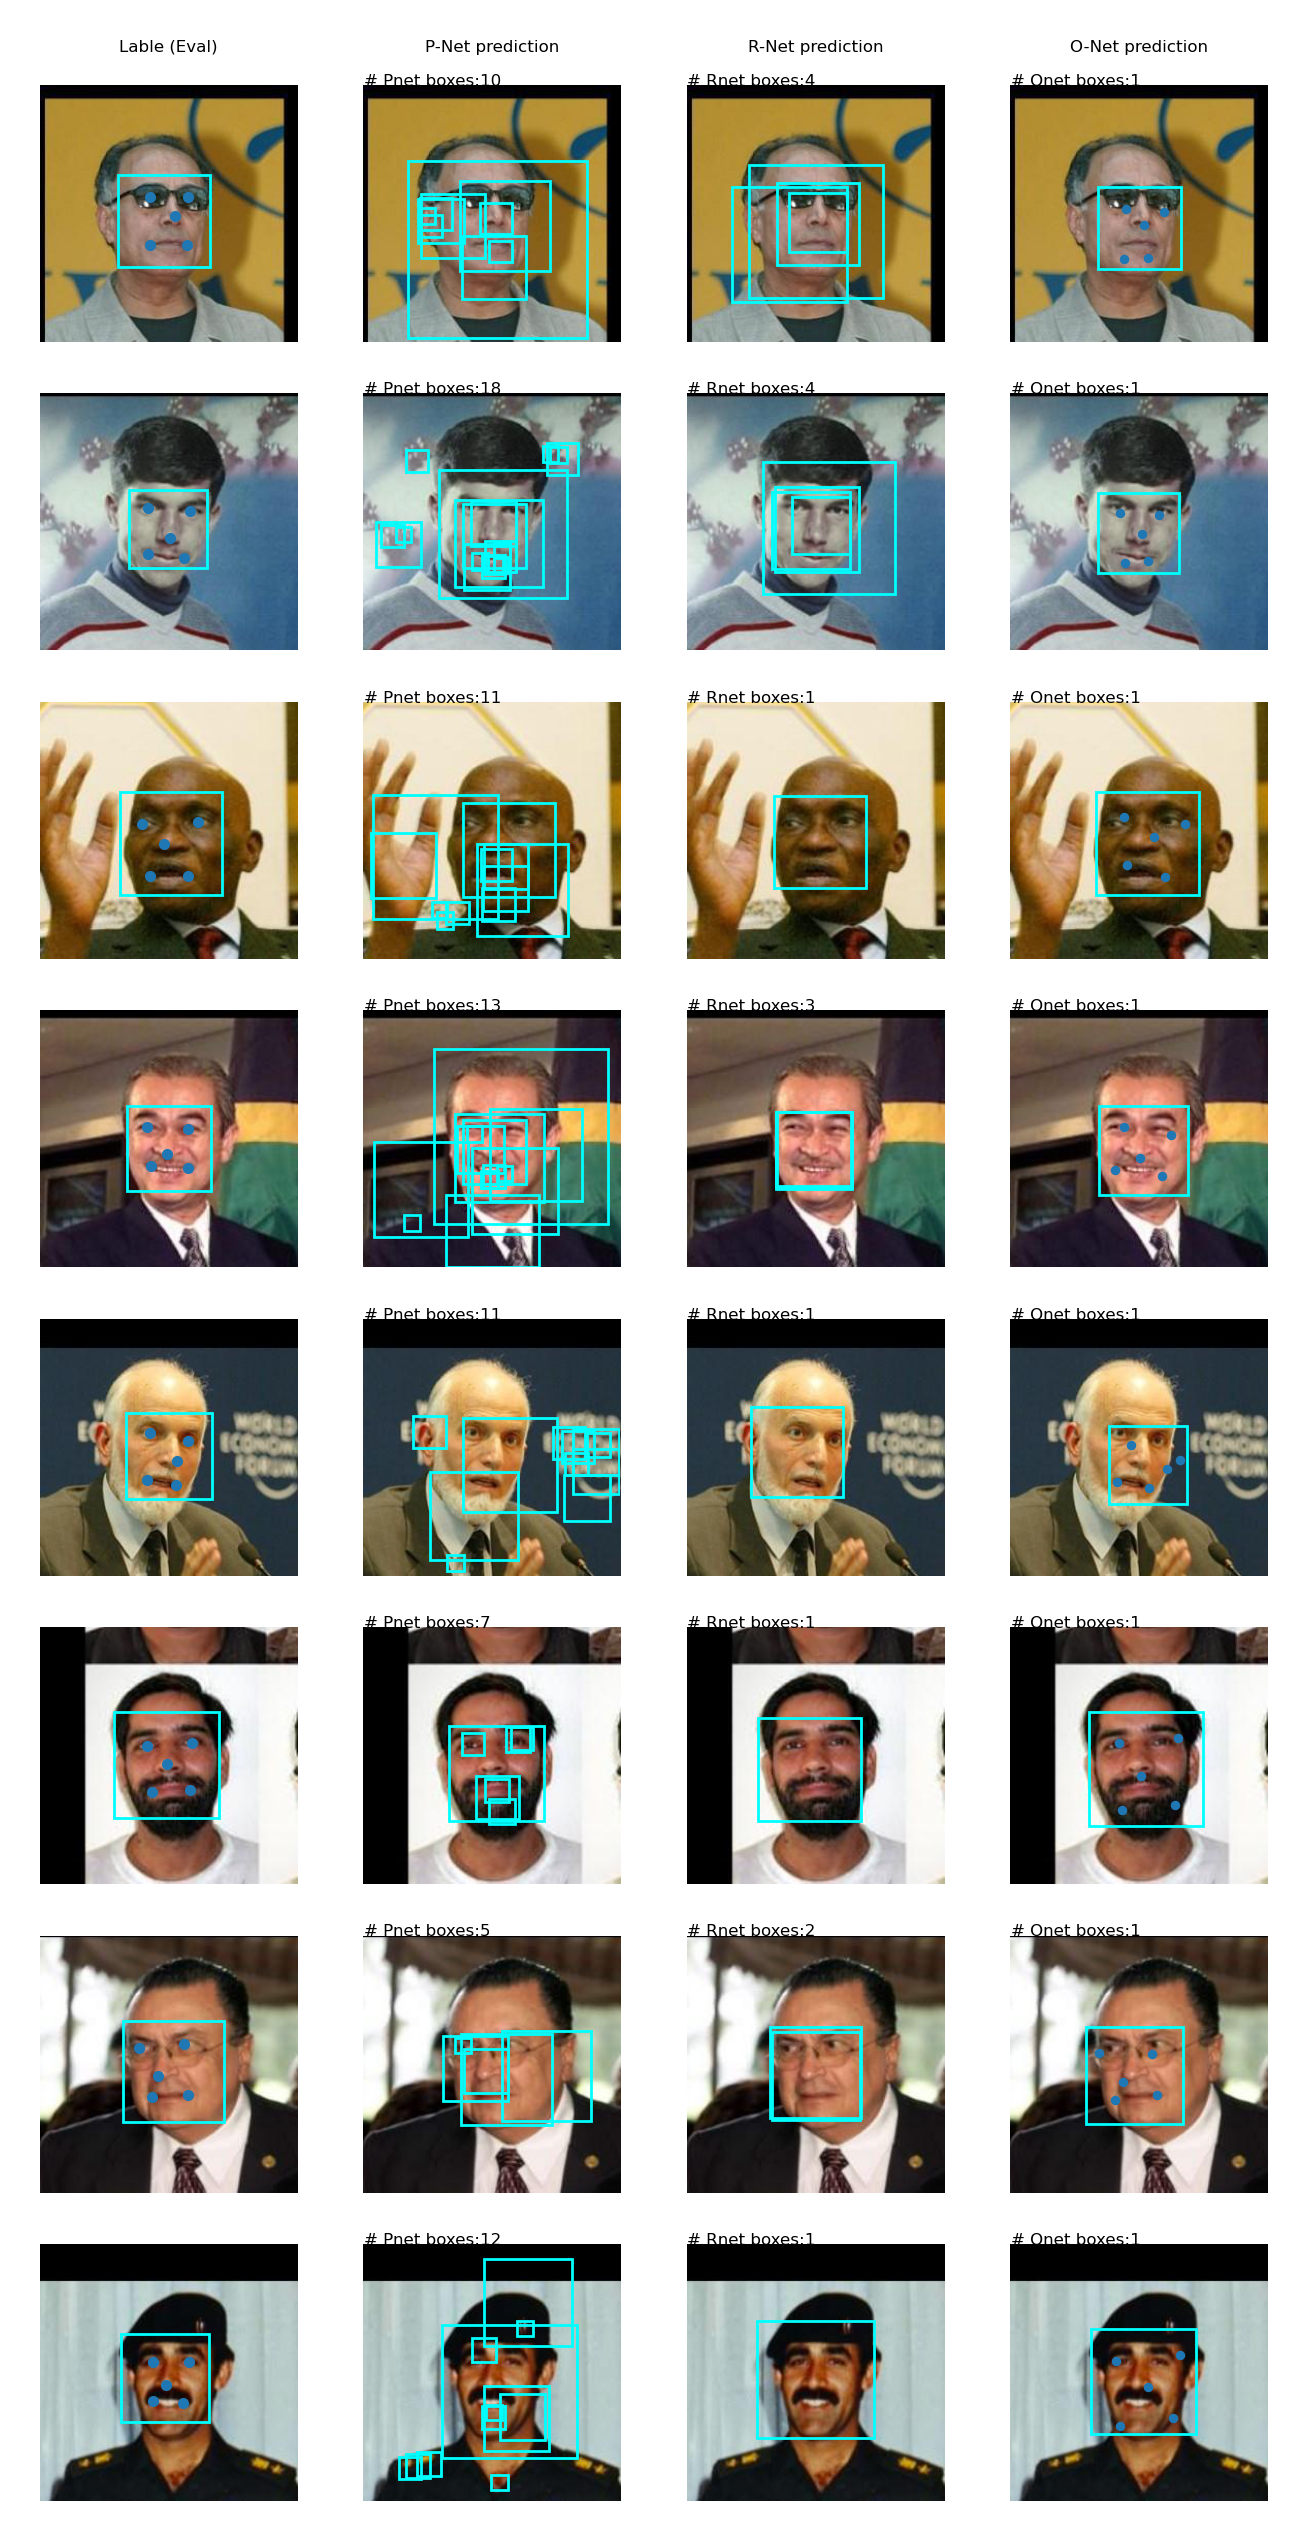

In [24]:
# get 8 fixed images
data_for_demo = landmark_dataset_txt_parser(landmark_eval_txt_path, landmark_data_dir,num_data=8)


# demo and plot
fig, ax = plt.subplots(8,4,dpi = 400, figsize=(4,8))

for i in range(len(data_for_demo)):
    img_pth, gts,p = data_for_demo[i]
    gts=np.array(gts)
    if gts.ndim is 1:
        gts = np.expand_dims(gts, 0)
        gts[:, :] = gts[:, (0, 2, 1, 3)]
    img = Image.open(img_pth)
    p_bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    r_bounding_boxes=rnet_boxes(img, rnet, p_bounding_boxes, show_boxes=False)
    try:
        o_bounding_boxes,ldmk=onet_boxes(img, onet, r_bounding_boxes)
    except:
        o_bounding_boxes,ldmk=[],[]
    
    ax[i,0].imshow(img)
    ax[i,0].scatter([p[j*2] for j in range(5)],[p[j*2+1] for j in range(5)],s=1)
    for b in gts:
        ax[i,0].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5));
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# Pnet boxes:'+str(len(p_bounding_boxes)),fontsize=3)
    for b in p_bounding_boxes[:100]:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
    
    ax[i,2].imshow(img)
    ax[i,2].text(0, 0, '# Rnet boxes:'+str(len(r_bounding_boxes)),fontsize=3)
    for b in r_bounding_boxes:
        ax[i,2].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
        
    ax[i,3].imshow(img)
    ax[i,3].text(0, 0, '# Onet boxes:'+str(len(o_bounding_boxes)),fontsize=3)
    for b in o_bounding_boxes:
        ax[i,3].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))  
    for l in ldmk:    
        ax[i,3].scatter([l[j*2] for j in range(5)],[l[j*2+1] for j in range(5)],s=0.5)

for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Lable (Eval)",fontsize=3)
ax[0][1].set_title("P-Net prediction",fontsize=3)
ax[0][2].set_title("R-Net prediction",fontsize=3)
ax[0][3].set_title("O-Net prediction",fontsize=3)
fig.show()
fig.savefig('demo_eval.png')